<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Italian Airports

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
import pandas as pd
import numpy as np
import warnings

from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import re

from time import time, sleep

In [2]:
# run to avoid warnings
warnings.filterwarnings('ignore')

In [3]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=0.8)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [5]:
options = webdriver.ChromeOptions() ;
prefs = {"download.default_directory" : "D:\Federico\02_Projects\01_Data_Science\05_Italian_Airports\datasets"};
options.add_experimental_option("prefs",prefs);

In [6]:
URL_example = "https://assaeroporti.com/wp-content/plugins/multipage_xls_reader/excel_file/2019_12.xls"

In [15]:
# download old monthly datasets
dr = webdriver.Chrome()
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for year in range(2000, 2022):

    for month in months:
            
        URL = f'https://assaeroporti.com/wp-content/plugins/multipage_xls_reader/excel_file/{year}_{month}.xls'
        
        dr.get(URL)
        
        sleep(2)
        
dr.quit()

Dataset for June 2001 is missing.

In [132]:
# Saving the scraping results as CSV
# results.to_csv('datasets/scrape/results_scrape.csv', encoding='utf-8', index=False)

In [4]:
# Loading the data from CSV for consistency reasons
results_m = pd.read_csv('datasets/scrape/results_scrape.csv')

In [5]:
results_m.head(17)

,index,job_title,company_name,company_rating,company_location,salary_amount,salary_estimate,multi_candidate,job_snippet
0,0,Student Research Assistant,University of New Mexico,4.0,"Albuquerque, NM 87106 (University Hts area)",$16 an hour,Not Available,Not Available,Informatics. Approaches include machine learni...
1,1,Data Scientist Manager,Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $178K - $225K a year,Not Available,Expert understanding of Python and other commo...
2,2,"Data Scientist, Senior",Booz Allen Hamilton,3.9,"Remote in Kirtland AFB, NM",Not Available,Estimated $95.2K - $121K a year,Not Available,"Experience with natural language processing, s..."
3,3,Solution Architecture Manager,Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $179K - $227K a year,Not Available,"One or more programming languages (i.e. C#, Ja..."
4,4,"Manager, Cognitive and AI - Remote",KPMG,3.9,"Remote in Albuquerque, NM 87110",Not Available,Estimated $122K - $154K a year,Not Available,Manage all Cognitive projects and Cognitive an...
5,5,Software Engineer (JR),Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $102K - $129K a year,Not Available,The successful candidate will have experience ...
6,6,Data Science Manager,Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $120K - $152K a year,Not Available,The successful candidate will be experienced w...
7,7,"Software Engineer, Manager - Tax Analysis & De...",Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $150K - $190K a year,Not Available,Experience working with one or more from the f...
8,8,"Lead Software Engineer, Tax Analysis & Debt In...",Deloitte,3.9,"Albuquerque, NM 87102 (Downtown area)",Not Available,Estimated $129K - $163K a year,Not Available,Experience working with one or more from the f...
9,9,Sr. Software Engineer,Alaka`ina Foundation Family of Companies,3.3,"Kirtland AFB, NM",Not Available,Estimated $106K - $135K a year,Not Available,The successful candidate will have experience ...


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [69]:
def clean_salary(salary):
    if 'month' in salary:
        salary = salary.replace(',', '')
        salary = re.findall(r'\d+', salary)
        salary = [int(i) for i in salary]
        salary = sum(salary) / len(salary)
        salary = salary * 12
    else:
        salary = salary.replace(',', '')
        salary = re.findall(r'\d+', salary)
        salary = [int(i) for i in salary]
        salary = sum(salary) / len(salary)
    return salary

In [70]:
# Testing the function. It works
print(clean_salary('$130,000 - $180,000 a year'))
print(clean_salary('$130,000 - $180,000 a month'))
print(clean_salary('$220,000 a year'))
print(clean_salary('$220,000 a month'))

155000.0
1860000.0
220000.0
2640000.0


In [71]:
# Applying the function to the salary column
us_fin['salary_amount'] = us_fin['salary_amount'].map(clean_salary)

In [72]:
us_fin

,job_title,company_location,salary_amount
0,"Senior Software Engineer, Backend (Speech to T...",NM,190000.0
1,Senior / Staff NLP Engineer (Speech to Text St...,NM,210000.0
2,Senior Data Engineer,NM,175000.0
3,Principal Data Engineer (Pre-IPO),NM,175000.0
4,Senior Machine Learning Engineer,NM,175000.0
...,...,...,...
12153,"Sr. Product Manager, Talent & Culture Portfolio",PA,118680.0
12154,Distinguished Solution Train Engineer (US),NJ,172380.0
12155,Construction Projects Manager I,PA,55739.0
12156,School Nurse - Camden,NJ,71500.0


### Save your results as a CSV

In [498]:
us_fin.to_csv('datasets/final/us_fin.csv', encoding='utf-8', index=False)

### Load in the the data of scraped salaries

In [85]:
df = pd.read_csv('datasets/final/us_fin.csv')

### Performing EDA  
A short quantitative description and visualisation of the data.  
  
  ***

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=1)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [92]:
df.describe(include='all')

,job_title,company_location,salary_amount
count,12158,12091,12158.000000
unique,8237,31,NaN
top,Senior Software Engineer,NY,NaN
freq,149,1794,NaN
mean,NaN,NaN,118876.890648
std,NaN,NaN,48635.401749
min,NaN,NaN,29.000000
25%,NaN,NaN,83267.000000
50%,NaN,NaN,114252.250000
75%,NaN,NaN,150000.000000


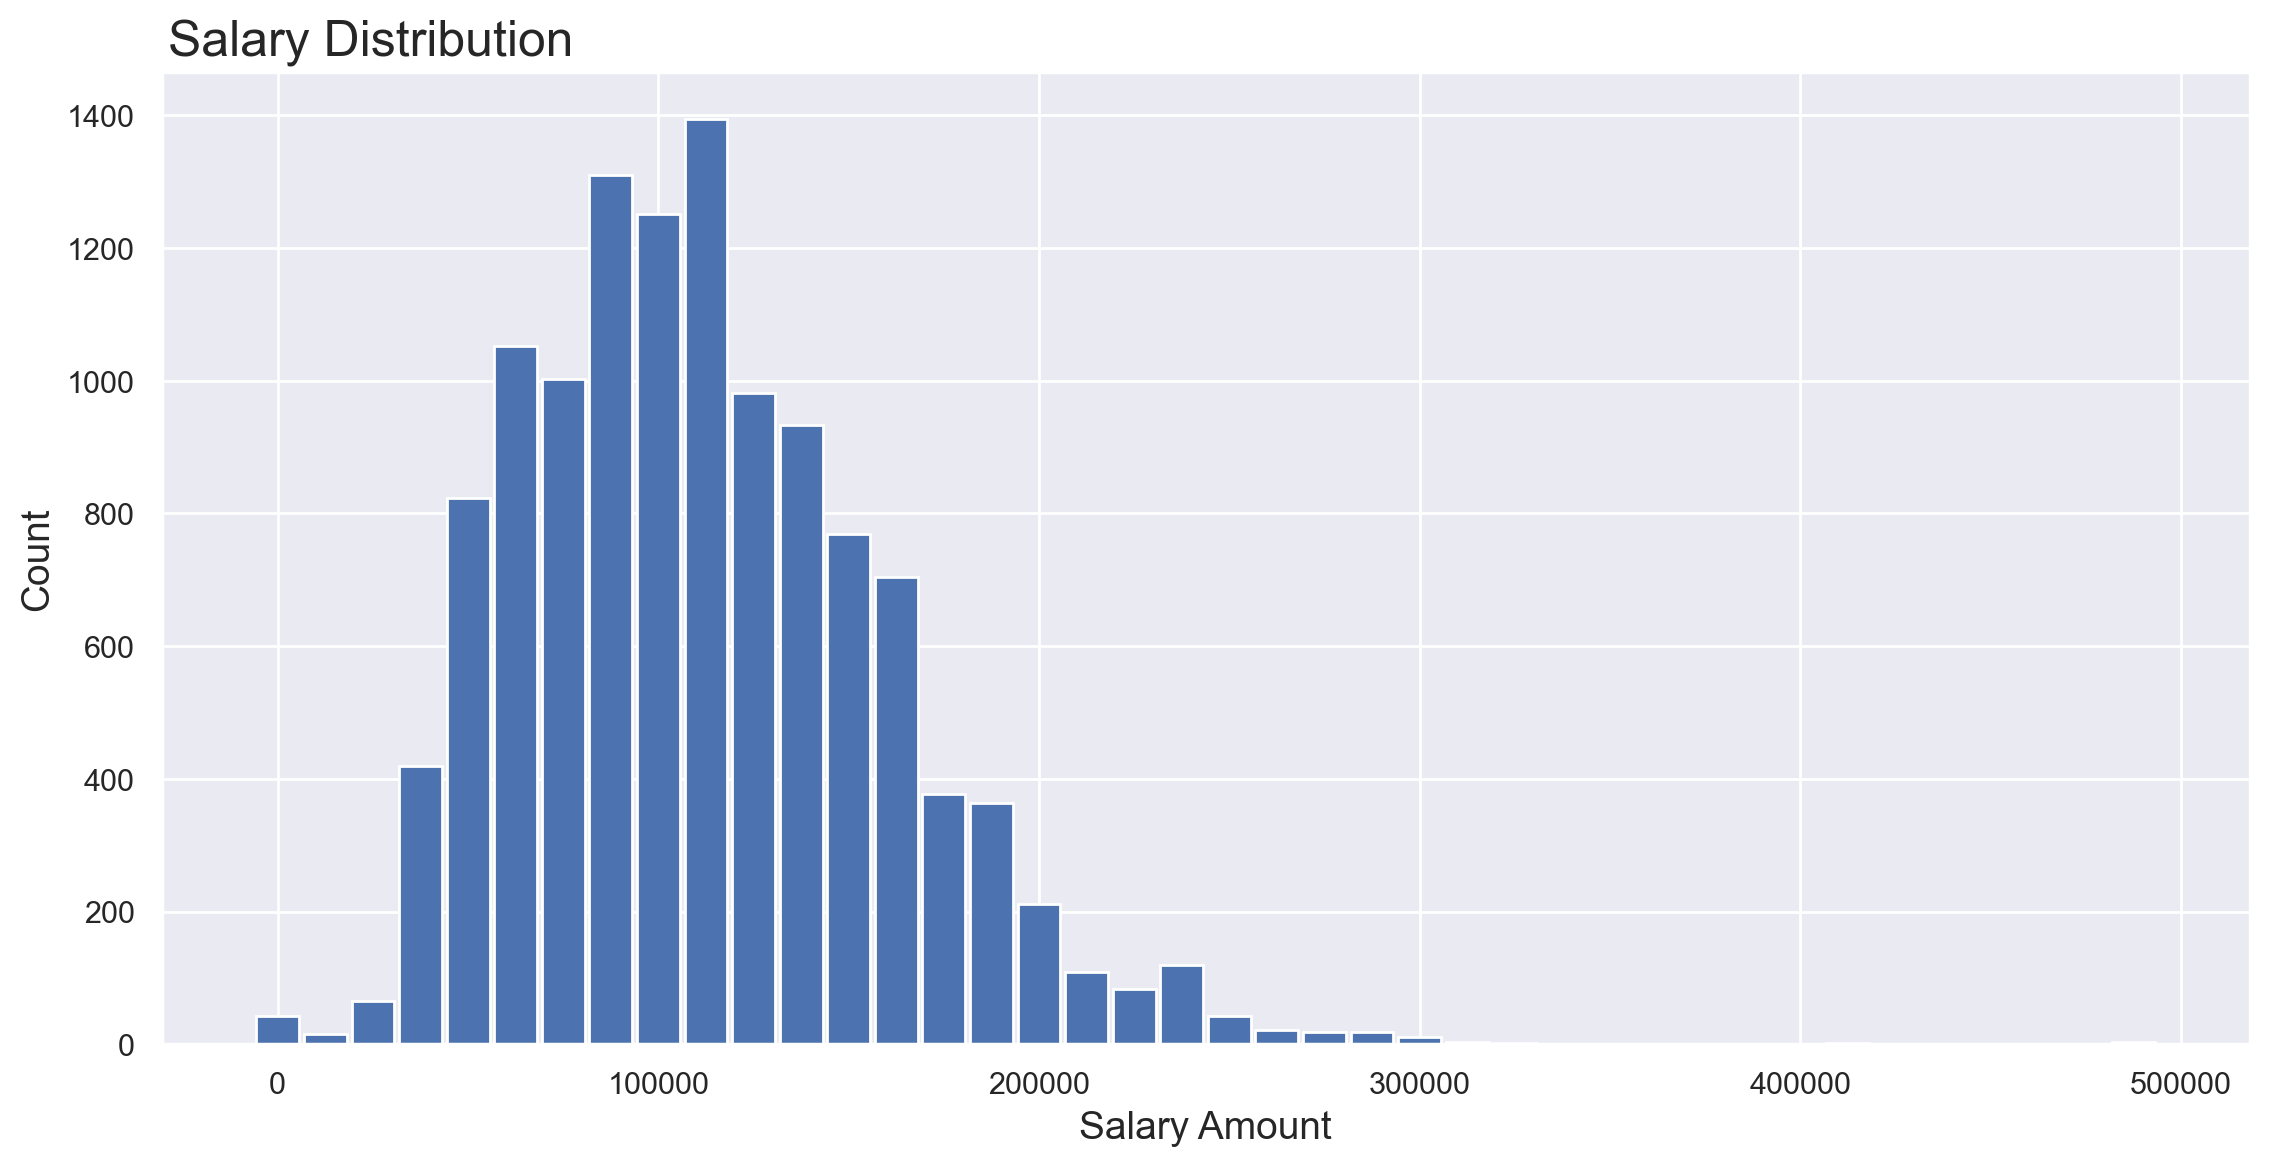

In [122]:
plt.figure(figsize=(12,6))
plt.hist(df.salary_amount, bins= 40, align='left', rwidth=0.9)
plt.title('Salary Distribution', x = 0.1, fontsize = 18)
plt.xlabel('Salary Amount', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

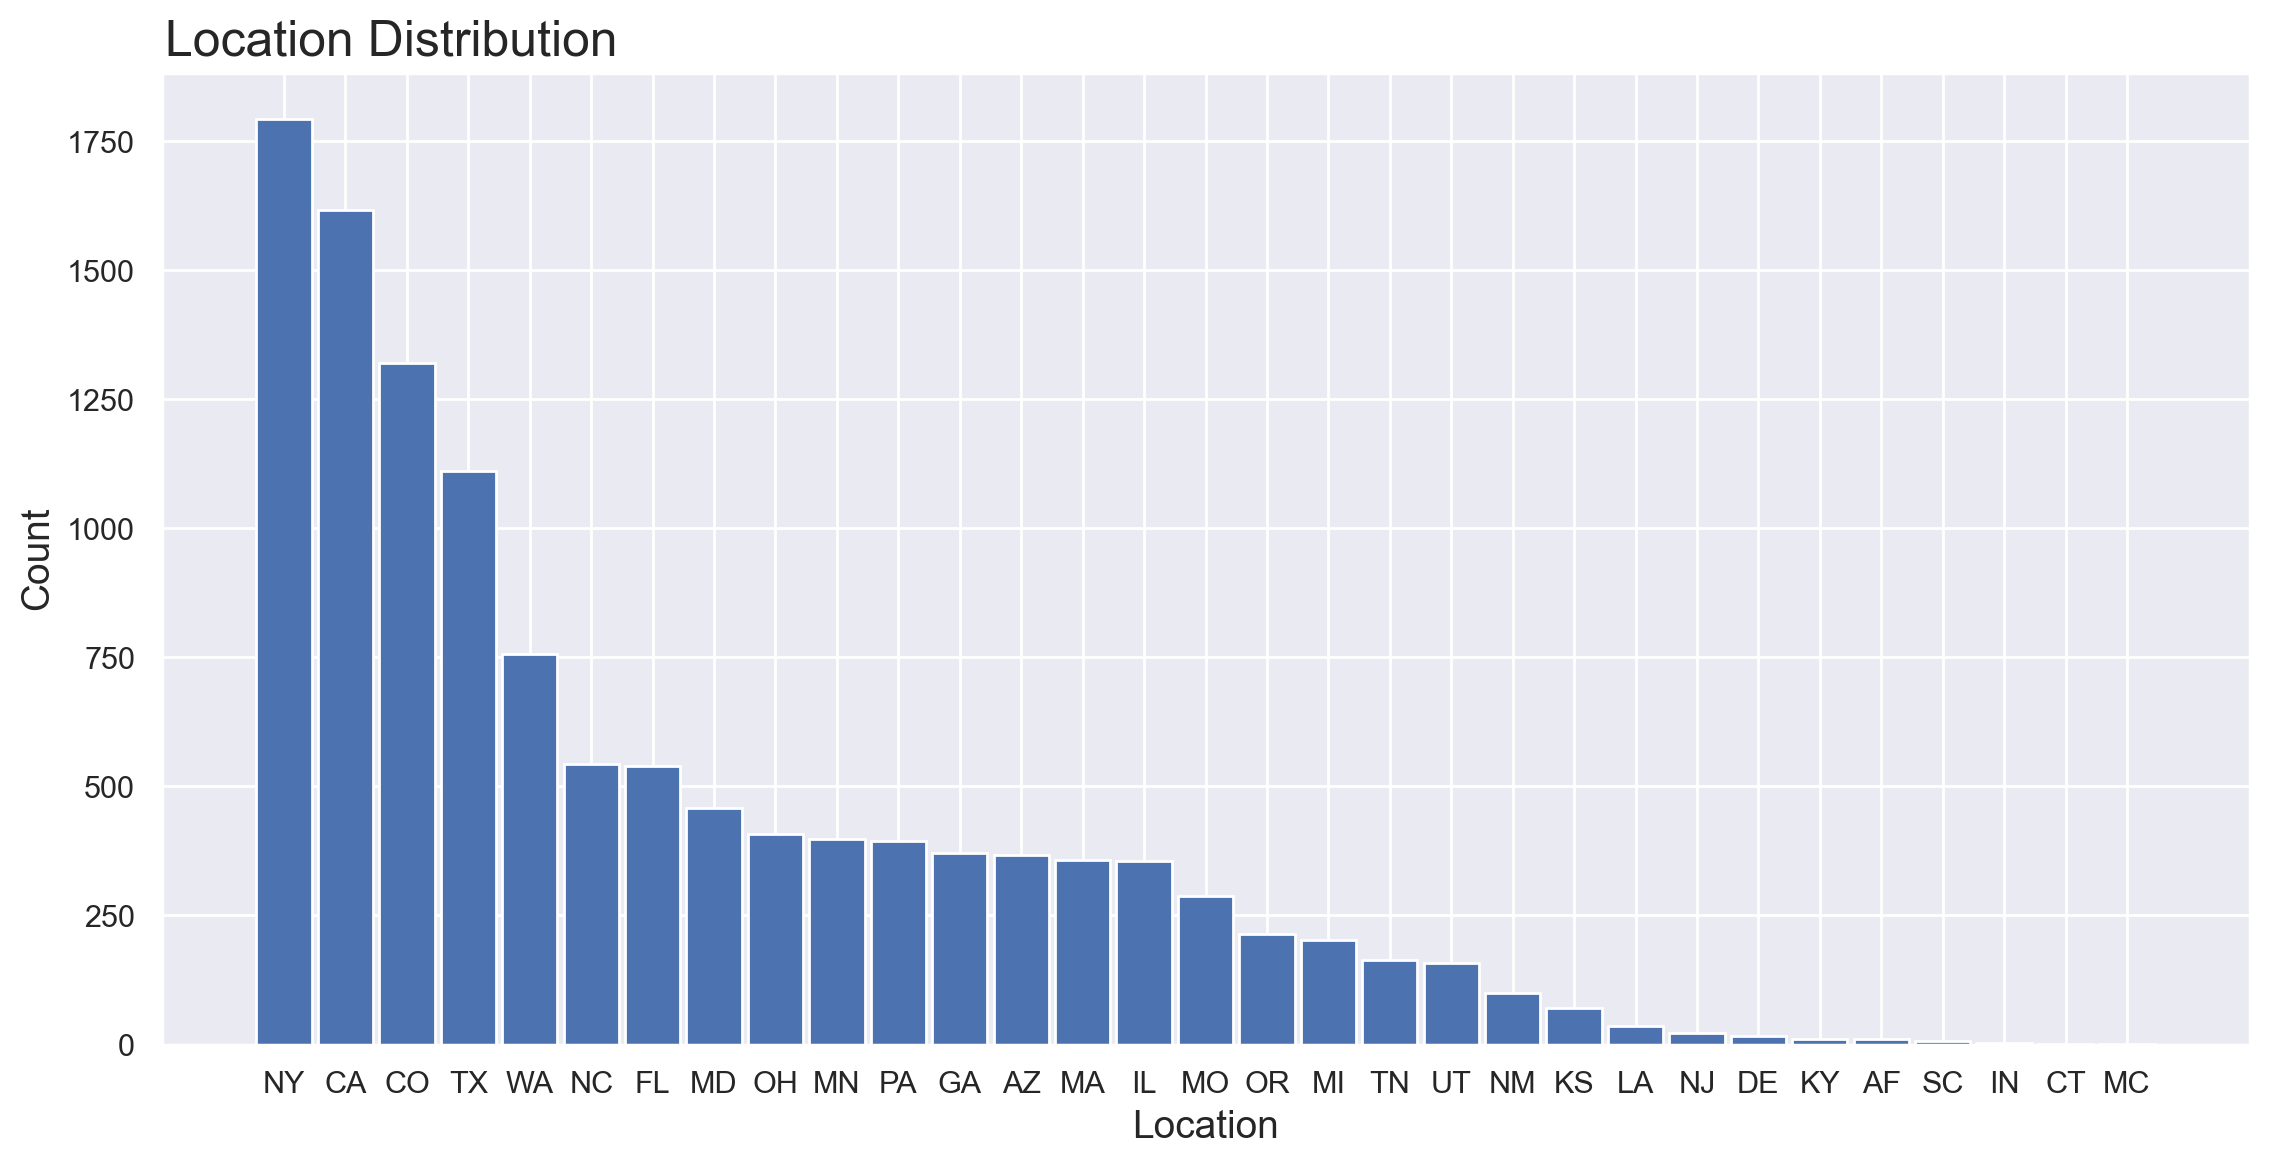

In [137]:
locs = df.company_location.value_counts().index
locs_counts = df.company_location.value_counts().values

plt.figure(figsize=(12,6))
plt.bar(locs, locs_counts, width=0.9)
plt.title('Location Distribution', x = 0.11, fontsize = 18)
plt.xlabel('Location', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [74]:
median = df.salary_amount.median()
print(median)

114252.25


In [75]:
def high_salary(row):
    median = df.salary_amount.median()
    if row['salary_amount'] >= median:
        return 1
    else:
        return 0

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [524]:
# Saving the modified dataframe as CSV
df.to_csv('datasets/df.csv', encoding='utf-8', index=False)

In [142]:
# Loading the data from CSV for consistency reasons
df = pd.read_csv('datasets/df.csv')

In [147]:
# Using only location as feature
df_dum = pd.get_dummies(df, columns=['company_location'], drop_first=True)
df_dum.drop(columns=['job_title', 'salary_amount'], inplace=True)
df_dum.head()

,high_salary,company_location_AZ,company_location_CA,company_location_CO,company_location_CT,company_location_DE,company_location_FL,company_location_GA,company_location_IL,company_location_IN,...,company_location_NM,company_location_NY,company_location_OH,company_location_OR,company_location_PA,company_location_SC,company_location_TN,company_location_TX,company_location_UT,company_location_WA
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


#### Decision Tree with Grid Search CV

In [246]:
# define gridsearch parameters
dtree_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]}


# define the model
dtree = DecisionTreeClassifier(random_state = 1)

# instantiate the gridsearch
dtc_gs = GridSearchCV(dtree, dtree_params, cv=5, n_jobs=10, verbose=1)

# find the fit in the gridsearch
dtc_gs.fit(X_train, y_train)

# pull out the model with the best parameters found in the gridsearch
dt_best = dtc_gs.best_estimator_

# calculate scores
dt_train = dt_best.score(X_train, y_train)
dt_test = dt_best.score(X_test, y_test)
dt_cv = (cross_val_score(dt_best, X_train, y_train, cv = 10)).mean()

# collect the scores in a dataframe to compare different models later
dt_df = pd.DataFrame([dt_train, dt_test, dt_cv], index = ['train', 'test', 'cv'], columns = ['Decision Tree'])

print('Decision Tree Classifier Scores: \n')
print('train score: ', dt_train)
print('test score: ', dt_test)
print('CV score: ', dt_cv)

Fitting 5 folds for each of 1936 candidates, totalling 9680 fits
Decision Tree Classifier Scores: 

train score:  0.5728973884433477
test score:  0.5633223684210527
CV score:  0.5691990323085447


Feature Importance & Model Coefficients

In [247]:
# Collecting the model coefficients in a dataframe
dt_coef = pd.DataFrame(dt_best.feature_importances_, columns=['importance'], index=X.columns)
dt_coef.sort_values(by = 'importance', ascending = False)[:10]

,importance
company_location_NY,0.351696
company_location_CA,0.264177
company_location_FL,0.074481
company_location_MO,0.063648
company_location_LA,0.042600
company_location_AZ,0.033127
company_location_CO,0.023695
company_location_MA,0.021270
company_location_IL,0.018555
company_location_GA,0.018213


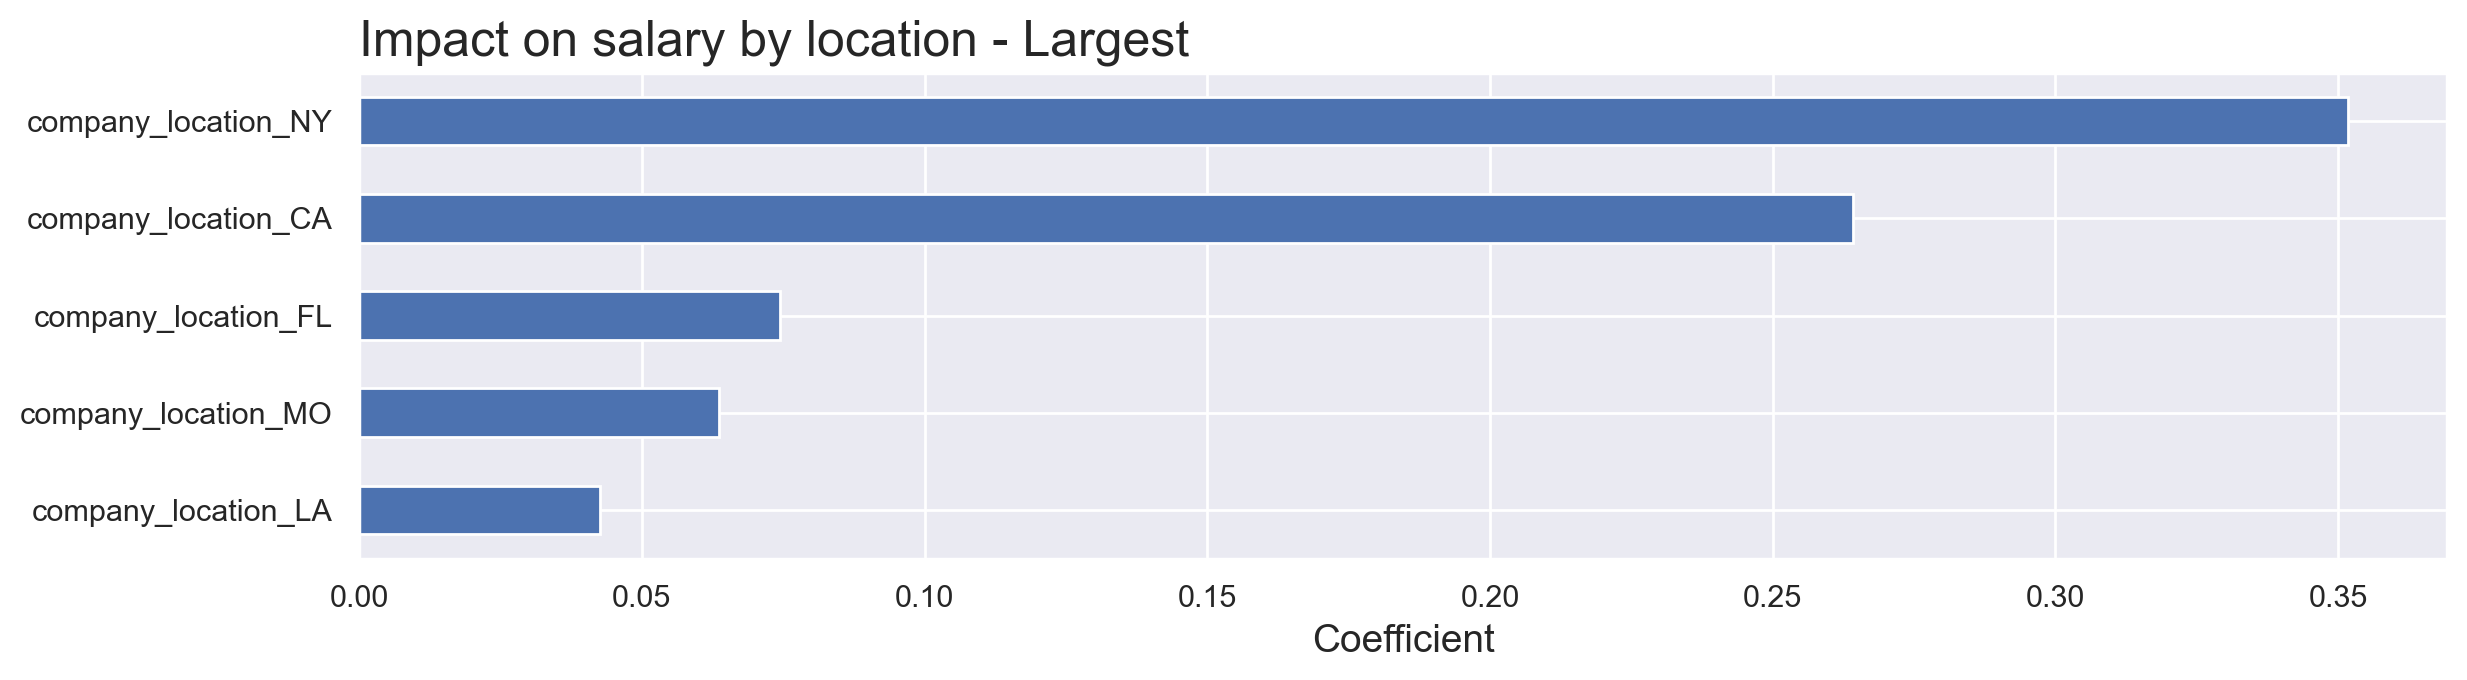

In [248]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Largest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

dt_coef['importance'].sort_values(ascending = True).tail(5).plot(kind='barh');

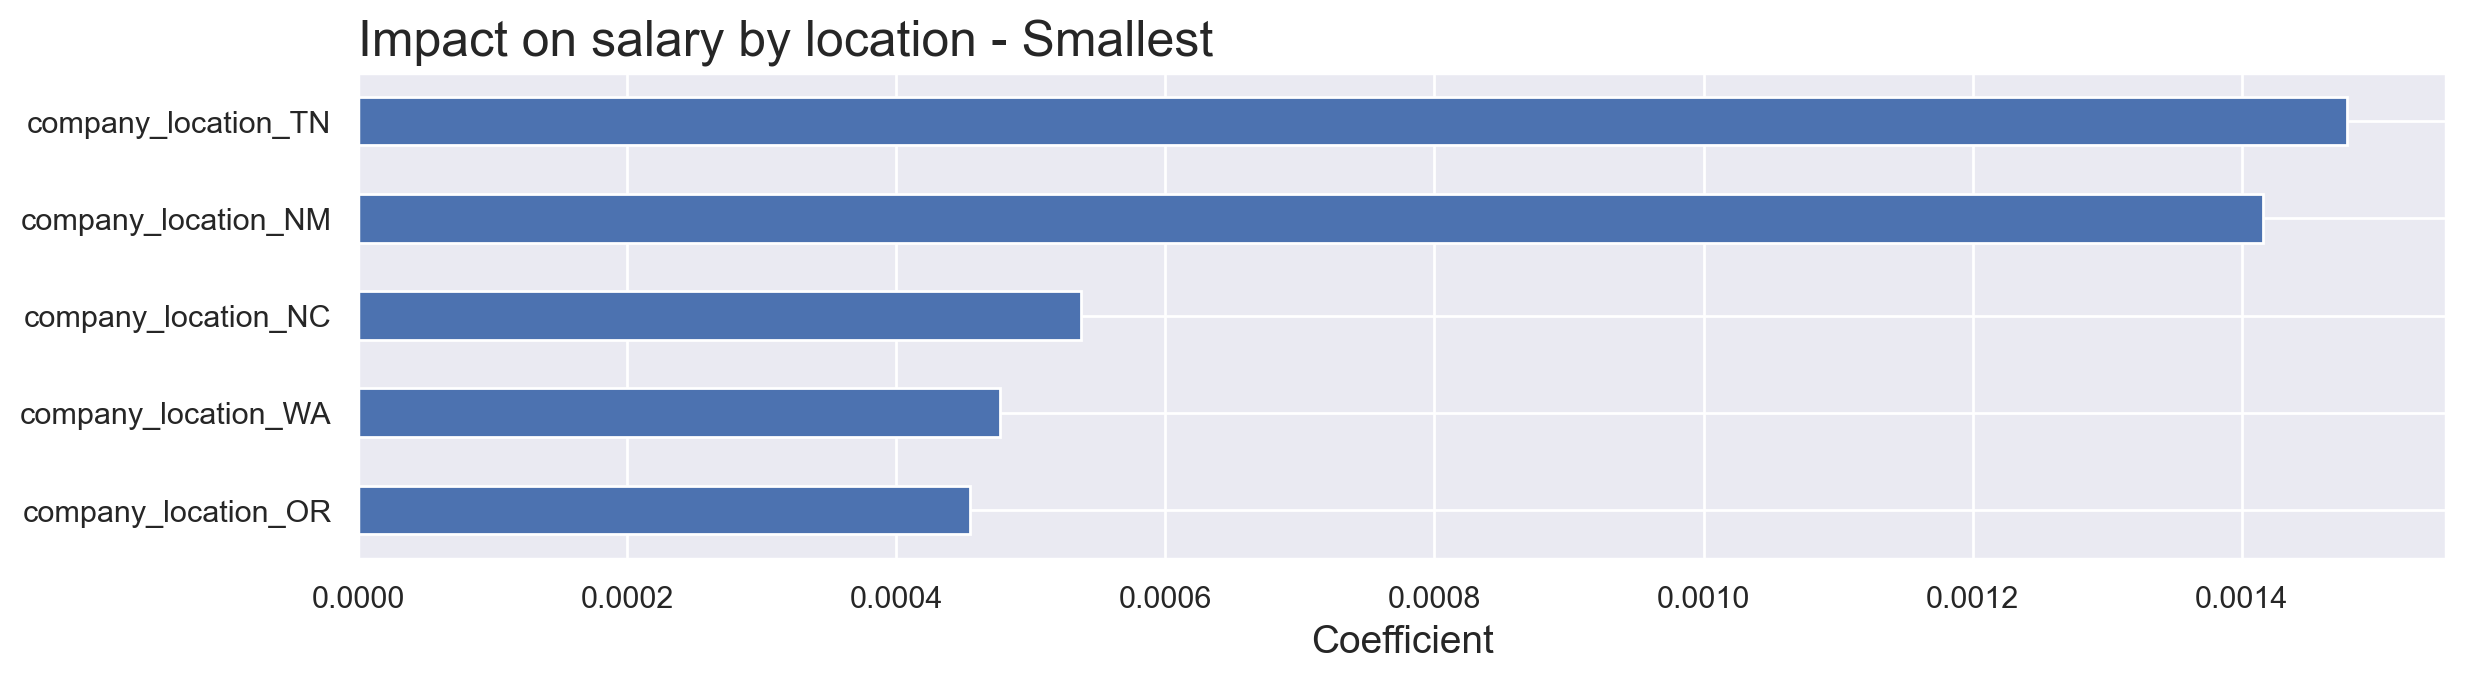

In [249]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Smallest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

dt_coef['importance'].sort_values(ascending = True).head(5).plot(kind='barh');

Feature importance in Decision Tree is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this model, the states of **New York**, **California** and **Florida** have the highest values, indicating that these locations have the largest impact on salaries.  
On the other side, **Oregon**, **Washington** and **North Carolina** have the smallest impact on salaries.
<br/><br/>

Classification Report

In [250]:
predictions = dt_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.53      0.55      1216
           1       0.56      0.59      0.58      1216

    accuracy                           0.56      2432
   macro avg       0.56      0.56      0.56      2432
weighted avg       0.56      0.56      0.56      2432



Confusion Matrix

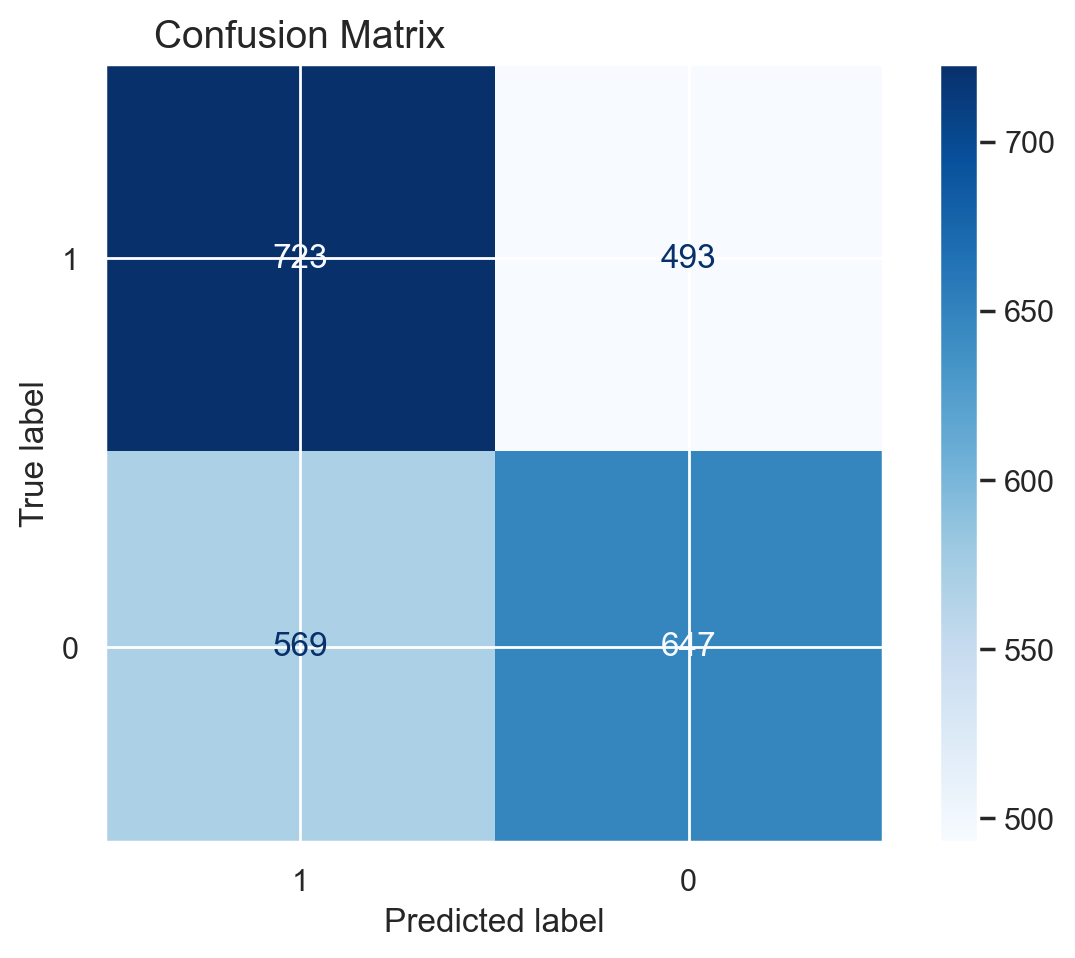

In [251]:
plot_confusion_matrix(dt_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', x = 0.25, fontsize = 14)
plt.show()

ROC-AUC Curve

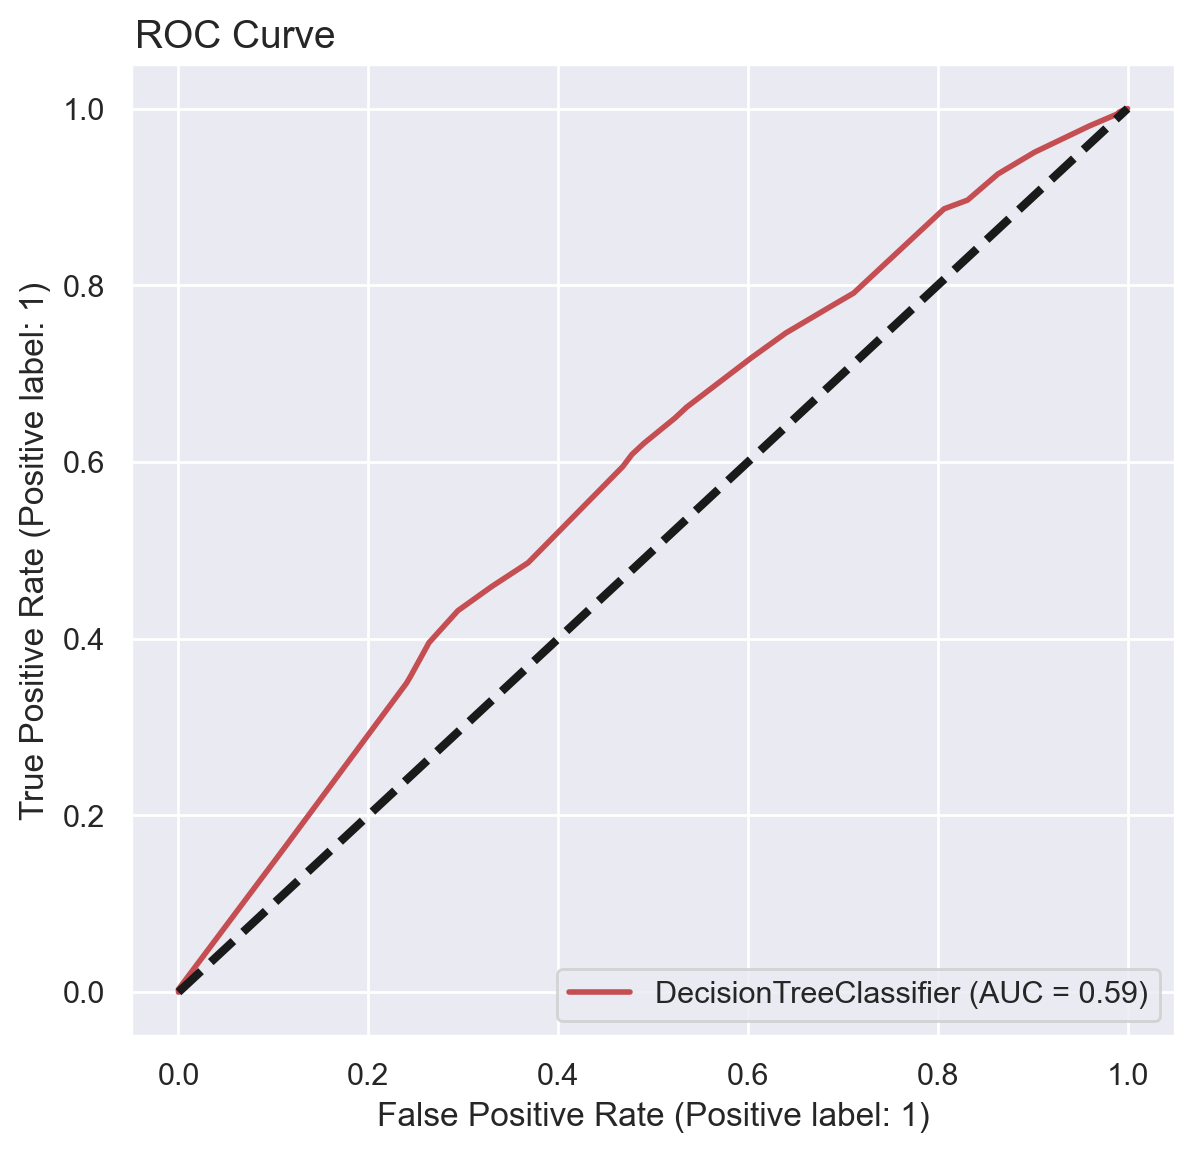

In [252]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(dt_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', x = 0.1, fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [253]:
print('ROC-AUC Score:', roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.5855269920792936


The f1-score is balanced between the two classes, however the accuracy of the model is pretty low.  
The area under the curve is **0.59**, which tells us that this model has a bad class separation capacity.  
<br/><br/>

#### Random Forest with Grid Search CV

In [255]:
# define gridsearch parameters
randf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 5, 7]}

# define the model
randf = RandomForestClassifier(random_state = 1)

# instantiate the gridsearch
rfc_gs = GridSearchCV(randf, randf_params, cv=5, n_jobs=10, verbose=1)

# find the fit in the gridsearch
rfc_gs.fit(X_train, y_train)

# pull out the model with the best parameters found in the gridsearch
rf_best = rfc_gs.best_estimator_

# calculate scores
rf_train = rf_best.score(X_train, y_train)
rf_test = rf_best.score(X_test, y_test)
rf_cv = (cross_val_score(rf_best, X_train, y_train, cv = 10)).mean()

# collect the scores in a dataframe to compare different models later
rf_df = pd.DataFrame([rf_train, rf_test, rf_cv], index = ['train', 'test', 'cv'], columns = ['Random Forest'])

print('Random Forest Classifier Scores: \n')
print('train score: ', rf_train)
print('test score: ', rf_test)
print('CV score: ', rf_cv)

Fitting 5 folds for each of 1650 candidates, totalling 8250 fits
Random Forest Classifier Scores: 

train score:  0.5728973884433477
test score:  0.5633223684210527
CV score:  0.5689933767271897


Feature Importance & Model Coefficients 

In [261]:
# Collecting the model coefficients in a dataframe
rf_coef = pd.DataFrame(rf_best.feature_importances_, columns=['importance'], index=X.columns)
rf_coef.sort_values(by = 'importance', ascending = False)[:10]

,importance
company_location_CA,0.289069
company_location_NY,0.285580
company_location_FL,0.068224
company_location_MO,0.055472
company_location_LA,0.037886
company_location_CO,0.033384
company_location_AZ,0.027120
company_location_GA,0.021127
company_location_MD,0.019171
company_location_IL,0.017197


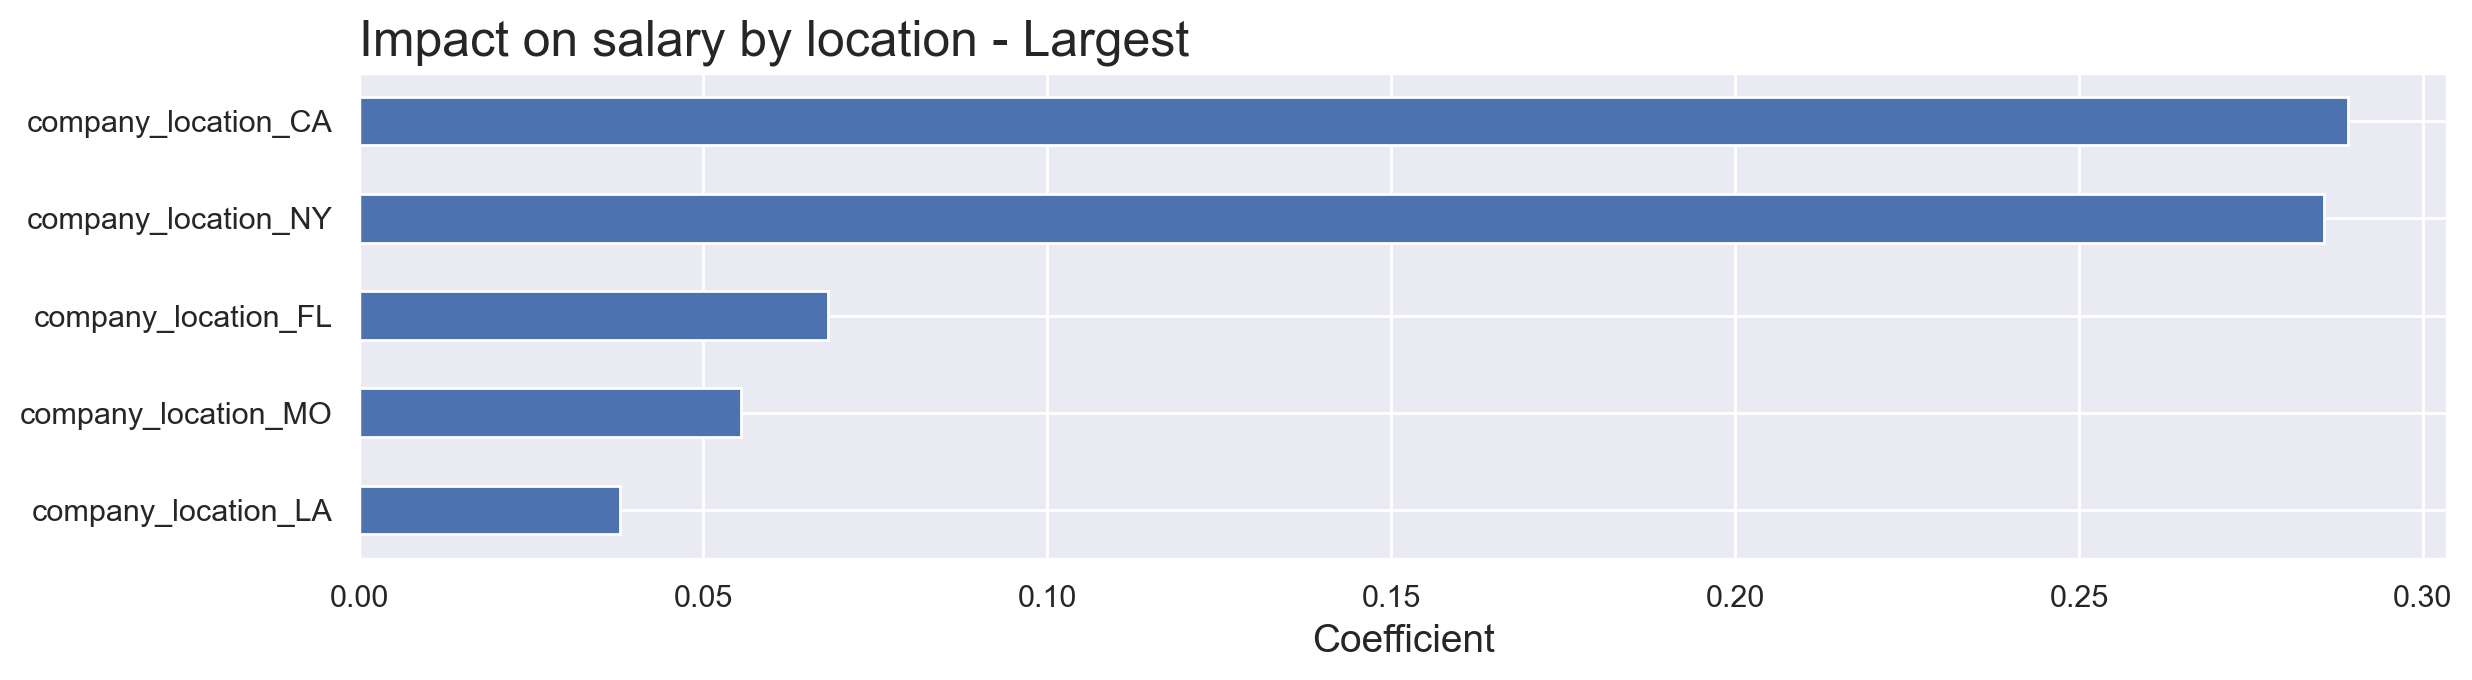

In [262]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Largest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

rf_coef['importance'].sort_values(ascending = True).tail(5).plot(kind='barh');

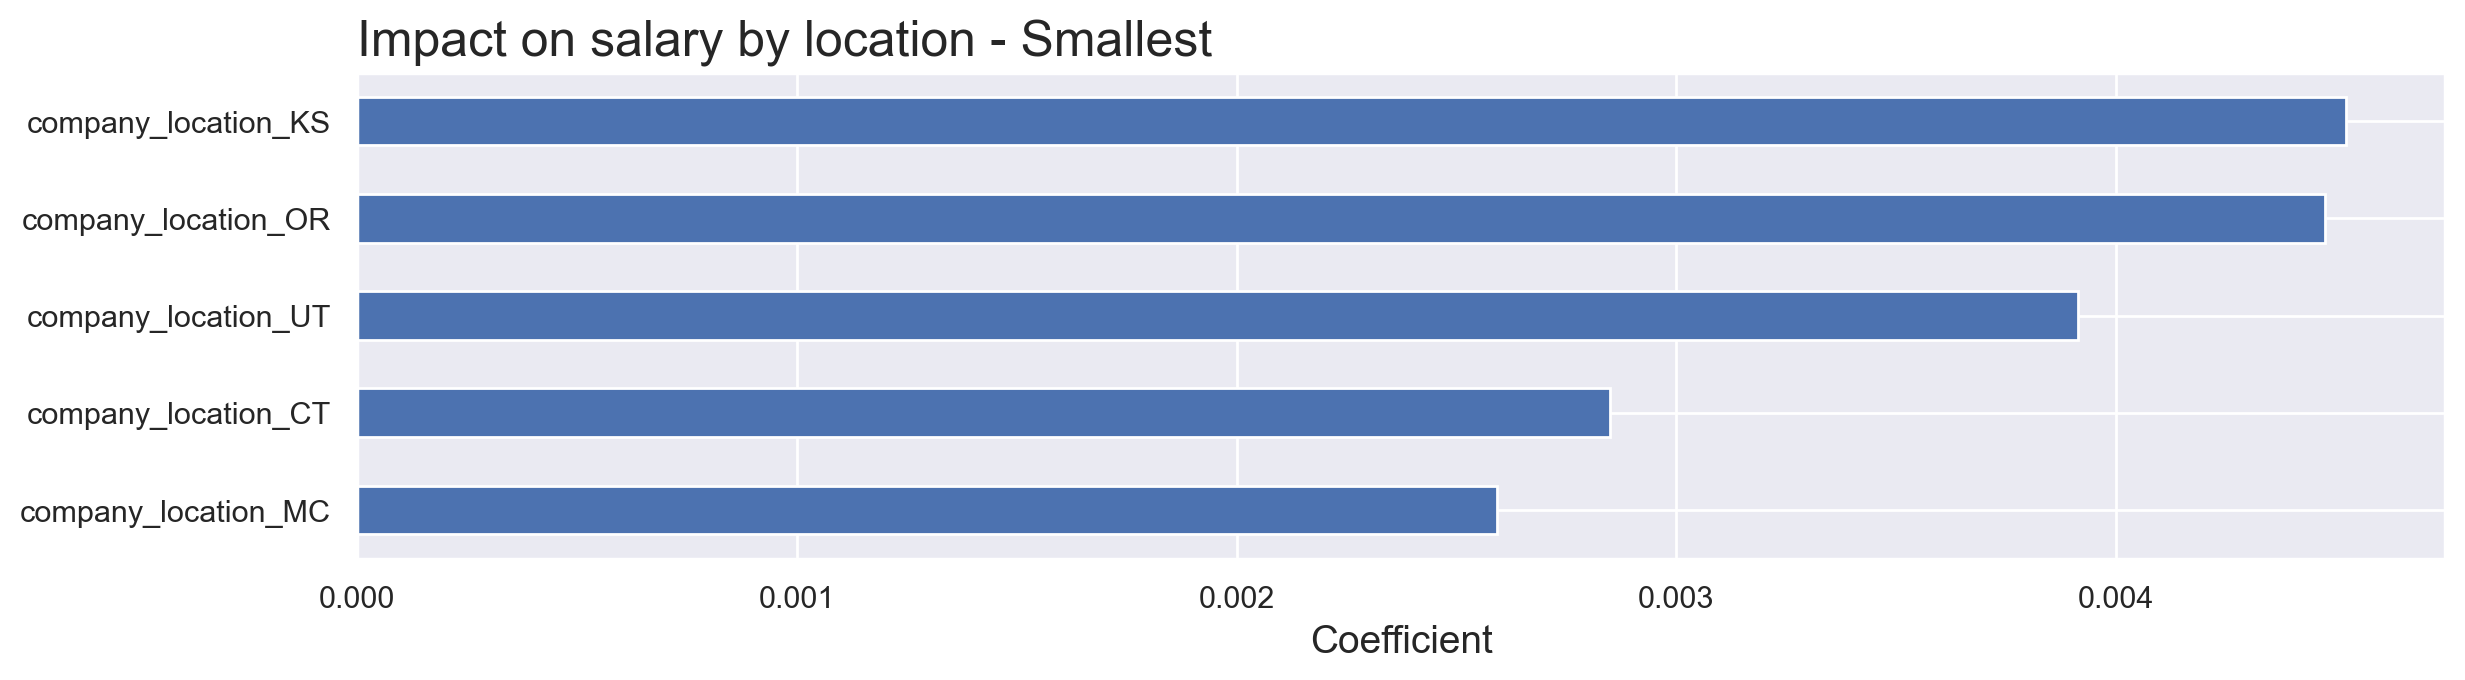

In [263]:
# Plotting the coefficients
plt.figure(figsize=(12,3))
plt.title('Impact on salary by location - Smallest', loc='left', fontsize = 18)
plt.xlabel('Coefficient', fontsize = 14)

rf_coef['importance'].sort_values(ascending = True).head(5).plot(kind='barh');

Feature importance in Random Forest is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this model, the states of **California**, **New York** and **Florida** have the highest values, indicating that these locations have the largest impact on salaries.  
On the other side, **Massachusetts**, **Connecticut** and **Utah** have the smallest impact on salaries.
<br/><br/>

Classification Report

In [264]:
predictions = rf_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.53      0.55      1216
           1       0.56      0.59      0.58      1216

    accuracy                           0.56      2432
   macro avg       0.56      0.56      0.56      2432
weighted avg       0.56      0.56      0.56      2432



Confusion Matrix

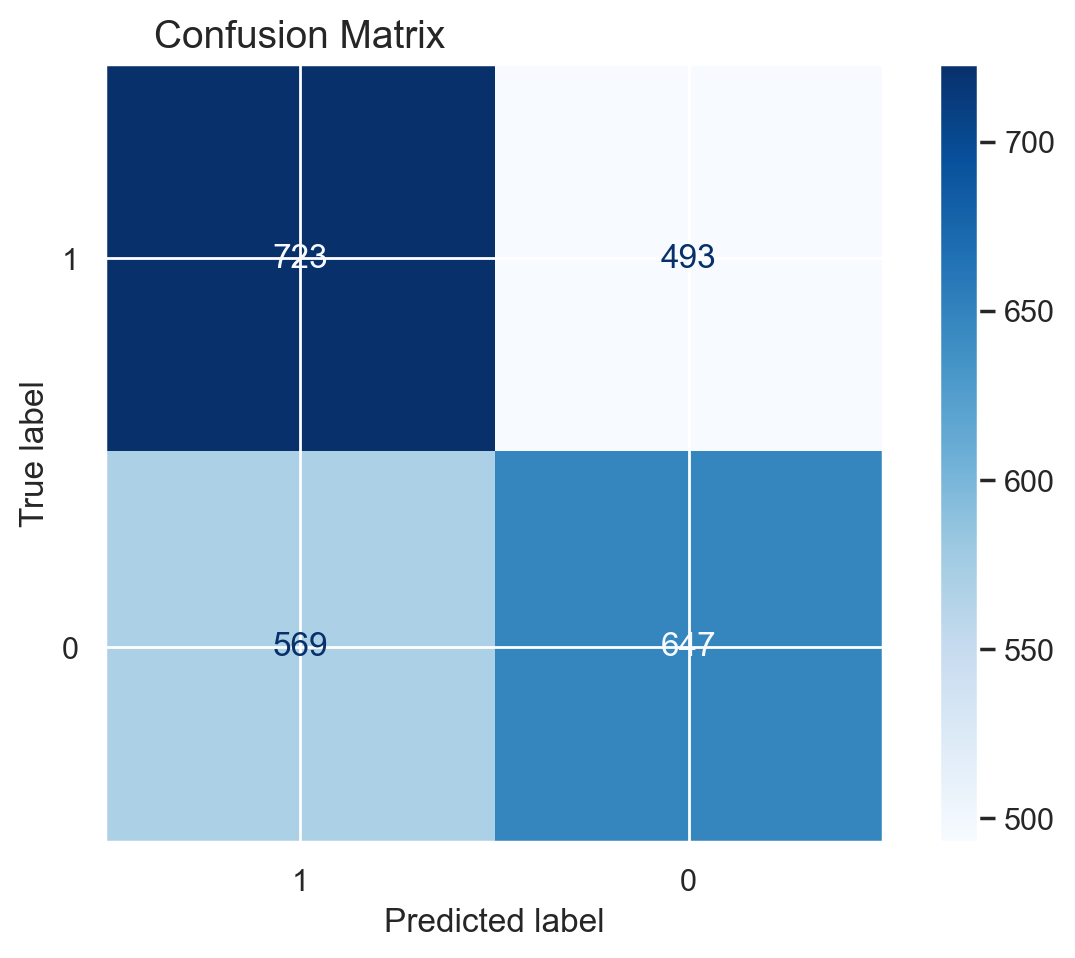

In [265]:
plot_confusion_matrix(rf_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', x = 0.25, fontsize = 14)
plt.show()

ROC-AUC Curve

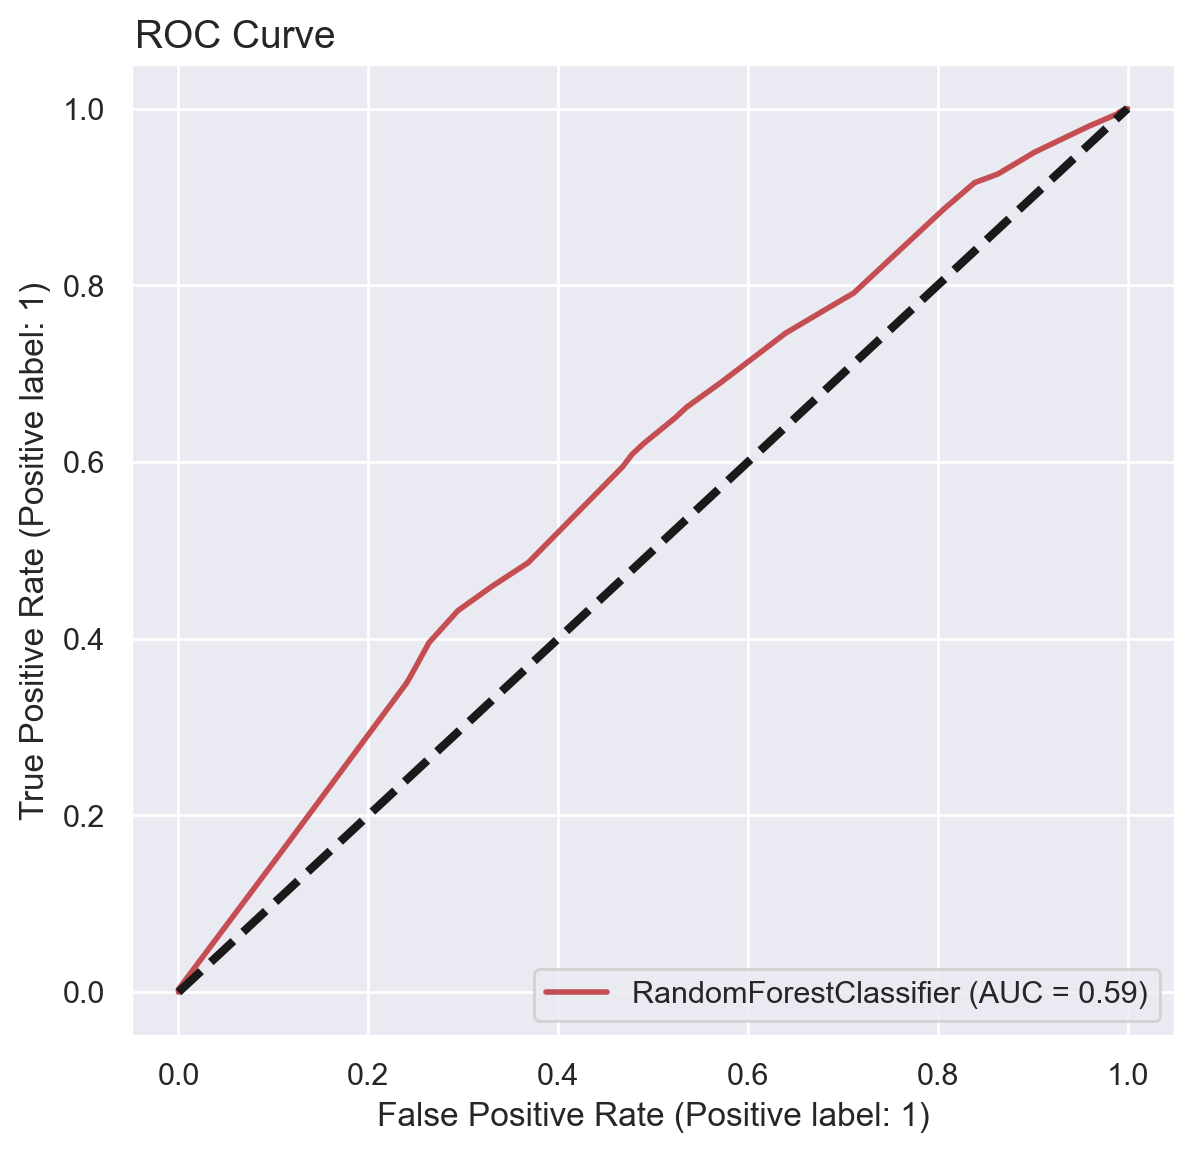

In [266]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(rf_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', x = 0.1, fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [267]:
print('ROC-AUC Score:', roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.5855269920792936


The f1-score is balanced between the two classes, however the accuracy of the model is pretty low.  
The area under the curve is **0.59**, which tells us that this model has a bad class separation capacity.  
<br/><br/>

#### Model Scores Evaluation

In [269]:
models_1 = pd.concat([logreg_df, dt_df, rf_df], axis = 1)
models_1

,Logistic Reg,Decision Tree,Random Forest
train,0.572897,0.572897,0.572897
test,0.564145,0.563322,0.563322
cv,0.568582,0.569199,0.568993


In the three models implemented above, **Decision Tree** achieved the highest CV score of **0.5691**  

The most important features for this model were **New York**, **California** and **Florida**. According to the Decision Tree Classifier, these locations have the biggest impact in predicting job salaries.

Although the Decison Tree Classifer performed the best, all the three model scores were quite close to one another, and were about 0.06 higher than the baseline of 0.5 indicating that the models made better predictions. However, it is likely that by adding other features these scores can improve.  
<br/><br/>